In [1]:
from dataset import *
import torch
print(torch.__version__)
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
from modules import *
from save_history import *

SEM_test = SEMDataTest('../data/val/images/')

1.5.0


In [4]:
from os.path import join

In [5]:
from czifile import CziFile

path = "../"

In [8]:
with CziFile(join("test2.czi")) as czi:
    
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)

In [9]:
image_arrays.shape # (1,1,1,tiempo,altura,pixeles,pixeles,1)

(1, 1, 1, 60, 17, 880, 836, 1)

In [ ]:
for x in range (0,60):
    img = image_arrays[0, 0, 0, x, 0, :, :, 0]
    plt.imsave(join("testPNG", str(x)+".png"), img, cmap='gray_r') #guarda en escala de grises invertido

In [2]:
torch.cuda.is_available()

True

In [6]:
model = torch.load('../model_epoch_100.pwf', map_location=torch.device('cpu')).module.cpu()
model.eval()

C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\l_pip\Anaconda3\envs\Tesis\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original sourc

CleanU_Net(
  (Conv_down1): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down2): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_down3): Conv_down(
    (conv): Double_conv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))


In [7]:
SEM_test_load = torch.utils.data.DataLoader(dataset=SEM_test, num_workers=3, batch_size=1, shuffle=False)
    
for images_t in SEM_test_load:
    stacked_img = torch.Tensor([])
    
    for index in range(images_t.size()[1]):
        print(index)
        with torch.no_grad():
            image_t = Variable(images_t[:, index, :, :].unsqueeze(0))
            
            # print(image_v.shape, mask_v.shape)
            output_t = model.forward(image_t)
            output_t = torch.argmax(output_t, dim=1).float()
            stacked_img = torch.cat((stacked_img, output_t))
        break
    break


0


<IPython.core.display.Javascript object>


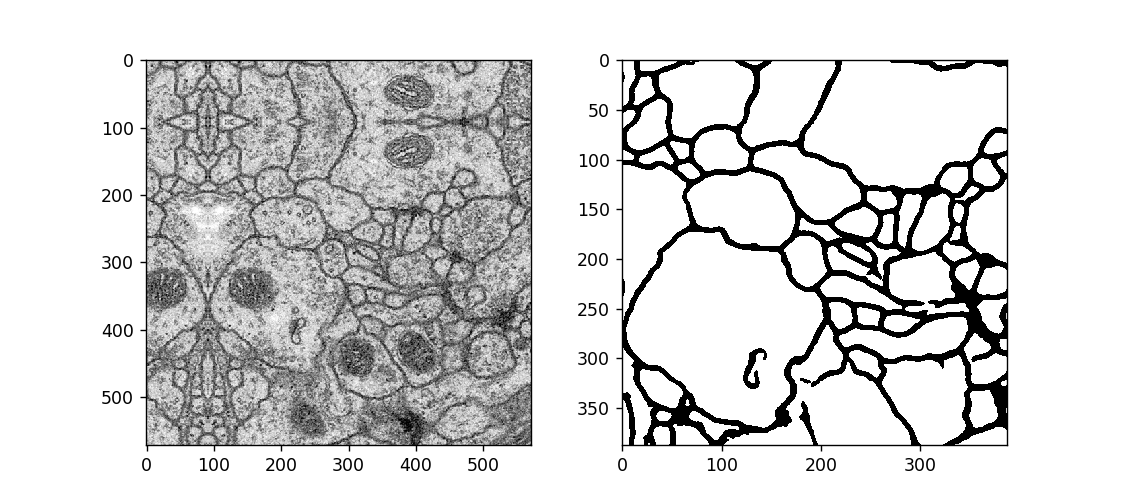

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(image_t.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output_t.numpy()[0], cmap=plt.cm.Greys_r)